# Convolutional Neural Networks
In this notebook we are going to implement AlexNet, a Convolutional Neural Network that has been presented in the paper *"ImageNet Classification with Deep Convolutional Neural Networks"*. The network on the paper has been trained on ImageNet, but since we have less computational capability and we don't want to wait too much time for training, we are going to use a subset of ImageNet, namely the CIFAR-10 dataset, which has less classes (10 instead of 1000).

## Preprocessing
The authors of the paper, spent an entire section talking about all the preprocessing techniques applied to the training set. They mainly applied 3 data augmentation techniques, namely:
* Fancy PCA: add to every pixel value a vector that is computed in the following way
$$
[\mathbb{p}_1, \mathbb{p}_2, \mathbb{p}_3][\alpha \lambda_1, \alpha \lambda_2, \alpha \lambda_3]^T
$$
where $\alpha$ is drawn from a Gaussian distribution, $\mathbb{p}_i$ is the $i^{th}$ principal component vector and $\lambda_i$ is the $i^{th}$ eigenvalue associated. 
* Reflections: take the reflection of an image
* Five crops: taking 5 patches of an image at random locations

Here we are focusing only on the first 2 pre-processing techniques. While the latter is already implemented in Pytorch, the former must be implemented from scratch. It is sufficient to implement it into a module and then treat that module as a pytorch transformation while we will load the dataset.

In [1]:
from torch import nn
import torch

class PCANorm(object):
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        start_shape = x.shape
        # Flatten the tensor so that you get [[r1, g1, b1], [r2, g2, b2]...]
        x_src = x.reshape(-1, 3)
        # Center the values around their means
        x_center = x_src - x_src.mean(0)
        # Compute the covariance matrix (we must transpose it since each
        # "observation" is a single row)
        x_cov = x_center.T.cov()
        # Compute the Eigen-values/vectors
        e_vals, e_vecs = torch.linalg.eigh(x_cov)
        # Sort eigen values
        perm = torch.argsort(e_vals)
        e_vals = e_vals[perm]
        e_vecs = e_vecs[:, perm]
        # Draw random noise from a Gaussian distribution (which is sampled once for each image)
        # In reality we are just going to use a fixed number
        # alpha = torch.distributions.normal.Normal(loc=0, scale=0.1).sample()

        # Compute the additive vector
        add_vect = torch.matmul(e_vecs, (self.alpha * e_vals).T)
        # Finally add the vector to each pixel in the image
        y = x_src + add_vect
        return y.reshape(start_shape)

## Dataset Loading
Now that we have define the missing transformation, let's laod the dataset. As already said, we are going to apply the transformation sequentially to each image while loading the dataset. Since the images on CIFAR are 32x32 we must also apply a scaling transformation to match the sizes of ImageNet images (227x227).

Compute Device: cuda
Label: Horse


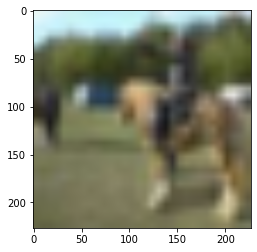

In [21]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as T
from matplotlib import pyplot as plt
from torch import nn

# Setup CUDA device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Compute Device: {device}')

# Get the number of cpus so that we can maximize parallel data loading
import multiprocessing
num_workers = multiprocessing.cpu_count()

# Load the dataset and return its dataloader
def load_data(root: str, batch_size: int) -> (DataLoader, DataLoader):
    train_transform = T.Compose([
        T.ToTensor(),
        PCANorm(),
        T.Resize(227),
        T.RandomHorizontalFlip(),
    ])
    test_transform = T.Compose([
        T.ToTensor(),
        T.Resize(227),
    ])
    train_data = CIFAR10(root = root, train = True, transform=train_transform)
    train_data_loader = DataLoader(train_data, batch_size, num_workers)
    test_data = CIFAR10(root = root, train = False, transform=test_transform)
    test_data_loader = DataLoader(test_data, batch_size, num_workers)
    return (train_data_loader, test_data_loader)

# Define training/test datasets/loaders
batch_size = 64
train_data, test_data = load_data('./resources', batch_size)

# Show the sample of the batch
X, y = next(iter(train_data))
img, label = X[0], y[0]
plt.imshow(img.permute(1, 2, 0))

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print(f'Label: {class_names[label]}')

## Model Architecture
As any other convolutional network AlexNet is made of a preprocessing block followed by a fully connected block. The original paper also implemented a form of localized normalization which has been replaced by the more general Batch Normalization layer, hence we use it here after each convolutional block to better stabilize learning process.

In [22]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.pre_process = nn.Sequential(
            # We are getting 3 input channels, but we are training 64 different kernels in this layer
            # The size of those kernels is 1x11, with stride 4x4 and padding 2x2
            nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Second convolution block 
            nn.Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Third convolution block
            nn.Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            # Fourth convolution block
            nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            # Fifth convolution block
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),
        )

        self.classifier = nn.Sequential( 
            # First layer
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            # Second layer
            nn.Dropout(p = 0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=10, bias=True),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.pre_process(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)  
        return out 

# Move the model parameters on the GPU
model = AlexNet()
model.to(device)

AlexNet(
  (pre_process): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(384, 256, ke

## Training

In [6]:
import torch.optim as optim

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer hyperparameters
learning_rate = 5e-3
batch_size = 64
epochs = 20
# weight_decay = 5e-4
momentum = 0.9

# Define the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Define the training loop
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn) -> None:
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader, 0):
        # Do a forward pass to compute the loss with respect to the real value
        X, y = X.to(device), y.to(device)
        res = model(X)
        loss = loss_fn(res, y)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            sys.stdout.write(f"\rLoss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            sys.stdout.flush()

# Train the model
train_loop(train_data, model, loss_fn)

Loss: 0.848347 [44800/50000]

## Testing

In [7]:
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_data:
        X, y = X.to(device), y.to(device)
        out = model(X)
        _, pred = torch.max(out.data, 1)
        total += y.size(0)
        correct += (pred == y).sum().item()
        del X, y, out
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 67.39%
